In [1]:
#import jax.numpy as np
import numpy as np
import numpy as onp
import pandas as pd
#import jaxopt

In [2]:
from sklearn.datasets import load_svmlight_file

In [3]:
X_train, y_train_ = load_svmlight_file('tmc2007_train.svm', multilabel=True)
X_train = onp.array(X_train.todense())
X_train.shape

(21519, 30438)

In [4]:
X_test, y_test_ = load_svmlight_file('tmc2007_test.svm', multilabel=True)
X_test = onp.array(X_test.todense())
X_test.shape

(7077, 30438)

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
onehot_labeller = MultiLabelBinarizer()
y_train = onehot_labeller.fit_transform(y_train_).astype(int)
y_test = onehot_labeller.transform(y_test_).astype(int)

In [7]:
labels = onehot_labeller.classes_.astype(int)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [8]:
import matplotlib.pyplot as plt

(array([5.949e+03, 7.867e+03, 5.541e+03, 1.522e+03, 4.430e+02, 1.220e+02,
        5.600e+01, 1.300e+01, 5.000e+00, 1.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

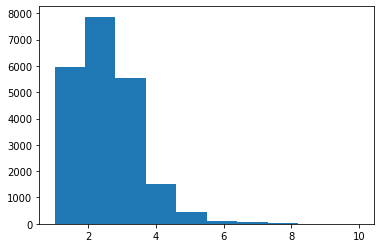

In [9]:
plt.hist(y_train.sum(axis=1))

In [29]:
y_test.sum()/(y_test.shape[0]*y_test.shape[1])

0.0887381658895012

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
def generate_crm_dataset(X, y, probas, n_samples=4, labels=labels):
    P = []
    A = []
    F = []
    R = []
    for i in range(len(probas)):
        for k in range(n_samples):
            
            p = probas[i,:]
            p = p.astype('float32')
            p /= p.sum()
            
            a = onp.random.choice(labels, p=p)
            A += [a]
            
            p = p[a]
            P += [p]
            
            x = X[i]
            F += [x]

            R += [int(y[i,a] > 0)]

    P = onp.array(P).reshape((len(P),1))
    A = onp.array(A).reshape((len(P),1))
    R = onp.array(R).reshape((len(P),1))
    F = onp.vstack(F)
    assert F.shape[0] == X.shape[0], (F.shape, X.shape, len(labels))
    return P, A, R, F

In [50]:
def micro_hammingloss(p,y):
    assert p.shape == y.shape
    pos = np.where( (p != y) & (y > 0) )
    neg = np.where( (p != y) & (y == 0) )
    fn = p[neg].sum()
    fp = (1-p[pos]).sum()
    return (fn+fp)/(p.shape[0])

In [14]:
def macro_hammingloss(test_probas, y_test):
    return onp.mean([
        micro_hammingloss(test_probas[:,k].reshape((len(y_test),1)), 
                          y_test[:,k].reshape((len(y_test),1))) 
        for k in range(y_test.shape[1])
    ])

---

In [15]:
def model(parameter, queries, embeddings):
    exponents = np.exp(np.dot(embeddings, parameter))
    num = exponents[onp.arange(embeddings.shape[0]), queries]
    res =  num / np.sum(exponents, axis=1)
    return res

In [16]:
def build_action_embeddings(features, labels):
    
    def onehotsingleaction(a):
        r = onp.zeros(len(labels))
        r[a] = 1
        return r
    
    result = [
        [onp.hstack([feature, 
                     onehotsingleaction(action)]) for action in labels] 
        for feature in features
    ]
    result = onp.array(result)
    return result

In [21]:
def build_action_embeddings_(features, labels):
    
    result = onp.zeros((len(features)*len(labels), 
                       features.shape[1]+len(labels)))
    #print(result.shape)
    for i in range(0, onp.floor(len(features)+1/len(labels)).astype(int)):
        for k in range(0, len(labels), 1):
            #print('i', i, 'k', k, 'i*+k', i*len(labels)+k)
            result[i*len(labels)+k,:features.shape[1]] = features[i,:]
            result[i*len(labels)+k,features.shape[1]+k] = 1
            #print(result[i+k,:])

    return result

In [17]:
def crm_loss(parameter, phi, A, P, R):
    pred = model(parameter, A.squeeze(), phi)
    W = pred / P.squeeze()
    l = np.sum((1-R).squeeze()*W) / np.sum(W)
    return l

In [18]:
from scipy.optimize import minimize as _min
def sp_optimize(crm_loss, init_parameter, *args):
    solution = _min(crm_loss, init_parameter, *args, method='L-BFGS-B')
    return solution.params

In [19]:
def model_eval(parameter, embeddings):
    exponents = np.exp(np.dot(embeddings, parameter))
    den = np.sum(exponents, axis=1).reshape(len(embeddings),1)
    res =  exponents / den
    return res

In [45]:
def iterate_model(beta, X, y, sampling_probas):
    #print('pp:',sampling_probas.mean(axis=0))
    P, A, R, F = generate_crm_dataset(
        X, y, sampling_probas, n_samples=1
    )
    #print('sum R:', R.sum(), 'sum y:', y.sum())
    phi = build_action_embeddings(F, labels)
    #print('generated CRM dataset from batch:', phi.shape)
    #optimizer = jaxopt.ScipyMinimize(fun=crm_loss, method="l-bfgs-b", maxiter=0)
    #solution = optimizer.run(beta, phi, A, P, R)
    
    def fn(beta):
        pred = model(beta, A.squeeze(), phi)
        W = pred / P.squeeze()
        l = np.sum((1-R).squeeze()*W) / np.sum(W)
        return l
    
    solution = _min(fn, beta, method='L-BFGS-B')
    newbeta = solution.x #.params
    return newbeta

In [51]:
def evaluate_model(beta, phi_test, y_test):
    beta_test_probas = model_eval(beta, phi_test)
    beta_test_probas /= beta_test_probas.sum(axis=1).reshape((len(y_test),1))
    return micro_hammingloss(beta_test_probas, y_test)

----

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier

In [24]:
from sklearn.random_projection import GaussianRandomProjection

In [57]:
fh = GaussianRandomProjection(n_components=1000)

X_train_h = fh.fit_transform(X_train)
X_test_h = fh.transform(X_test)
print(X_train_h.shape)

(21519, 1000)


In [32]:
def multioutput_to_label_probas(predictions, normalize=True):
    l = len(labels)
    if not hasattr(predictions, "shape"):
        n = predictions[0].shape[0]
        probas = onp.array([
            predictions[_][:,1] for _ in range(l)
        ]).T
    else:
        n = predictions.shape[0]
        probas = predictions
    if normalize:
        proba_sum = probas.sum(axis=1).reshape((n, 1))
        probas /= proba_sum
    return probas

In [52]:
print("pi_null micro test loss:", micro_hammingloss(np.zeros(y_test.shape), y_test))
print("pi_null macro test loss:", macro_hammingloss(np.zeros(y_test.shape), y_test))

pi_null micro test loss: 1.9522396495690264
pi_null macro test loss: 0.08873816588950122


In [53]:
pi_dummy = MultiOutputClassifier(DummyClassifier())
pi_dummy.fit(X_test_h, y_test)

pi_dummy_train_probas = pi_dummy.predict_proba(X_train_h)
pi_dummy_train_probas = multioutput_to_label_probas(pi_dummy_train_probas, normalize=False)
print("pi_dummy train loss:", micro_hammingloss(pi_dummy_train_probas, y_train))

pi_dummy_test_probas = pi_dummy.predict_proba(X_test_h)
pi_dummy_test_probas = multioutput_to_label_probas(pi_dummy_test_probas, normalize=False)
print("pi_dummy test loss:", micro_hammingloss(pi_dummy_test_probas, y_test))

pi_dummy train loss: 3.1726843219470737
pi_dummy test loss: 3.094090082269704


/home/e.diemert/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [54]:
pi_dummy = MultiOutputClassifier(DummyClassifier())
pi_dummy.fit(X_test_h, y_test)

pi_dummy_train_probas = pi_dummy.predict_proba(X_train_h)
pi_dummy_train_probas = multioutput_to_label_probas(pi_dummy_train_probas)
print("pi_dummy train loss:", micro_hammingloss(pi_dummy_train_probas, y_train))

pi_dummy_test_probas = pi_dummy.predict_proba(X_test_h)
pi_dummy_test_probas = multioutput_to_label_probas(pi_dummy_test_probas)
print("pi_dummy test loss:", micro_hammingloss(pi_dummy_test_probas, y_test))

pi_dummy train loss: 2.7107115221401283
pi_dummy test loss: 2.5371322025671947


/home/e.diemert/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [55]:
pi0 = MultiOutputClassifier(LogisticRegression(), n_jobs=6)

X_0, X_, y_0, y_ = train_test_split(X_train_h, y_train, test_size=.95)
pi0.fit(X_0, y_0)

pi0_train_probas = pi0.predict_proba(X_train_h)
pi0_train_probas = multioutput_to_label_probas(pi0_train_probas)
print("pi0 train loss:", micro_hammingloss(pi0_train_probas, y_train))

pi0_test_probas = pi0.predict_proba(X_test_h)
pi0_test_probas = multioutput_to_label_probas(pi0_test_probas)
print("pi0 test loss:", micro_hammingloss(pi0_test_probas, y_test))

pi0 train loss: 2.501372335887729
pi0 test loss: 2.370664449469601


In [37]:
pistar = ClassifierChain(LogisticRegressionCV(max_iter=1000, n_jobs=6))
pistar.fit(X_train_h, y_train)

KeyboardInterrupt: 

In [58]:
pistar = MultiOutputClassifier(LogisticRegressionCV(max_iter=1000, n_jobs=6))
pistar.fit(X_train_h, y_train)

MultiOutputClassifier(estimator=LogisticRegressionCV(max_iter=1000, n_jobs=6))

In [59]:
pistar_train_probas = pistar.predict_proba(X_train_h)
pistar_train_probas = multioutput_to_label_probas(pistar_train_probas)
print("pi* train loss:", micro_hammingloss(pistar_train_probas, y_train))

pistar_test_probas = pistar.predict_proba(X_test_h)
pistar_test_probas = multioutput_to_label_probas(pistar_test_probas)
print("pi* test loss:", micro_hammingloss(pistar_test_probas, y_test))

pi* train loss: 2.0595898974480398
pi* test loss: 2.002433499822705


In [40]:
import sys

In [60]:
phi_test = build_action_embeddings(X_test_h, labels)
phi_train = build_action_embeddings(X_train_h, labels)

In [ ]:
phi_test.shape

In [61]:
sampling_probas_static = sampling_probas_dynamic = pi0_train_probas
init = onp.random.normal(size=len(labels)+X_train_h.shape[1])
beta_static = np.array(init.copy())
beta_dynamic = np.array(init.copy())

beta_test_probas = model_eval(init, phi_test)
print('beta0 loss:', micro_hammingloss(beta_test_probas, y_test))
print('beta0 loss:', macro_hammingloss(beta_test_probas, y_test))

beta0 loss: 2.8066024106523546
beta0 loss: 0.12757283684783433


In [ ]:
batch = 100000200000#int(len(X_train)*.01)

for episod in range(30):
    start = episod*batch
    end = (episod+1)*batch
    X = X_train_h[0:end,:]
    y = y_train[0:end,:]
    print('*'*30, 'episod:', episod, 'samples:', end, '*'*30, file=sys.stderr)
    if episod > 0:
        beta_static = iterate_model(beta_static, X, y, sampling_probas_static[0:end,:])
        beta_dynamic = iterate_model(beta_dynamic, X, y, sampling_probas_dynamic[0:end,:])    
        sampling_probas_dynamic = model_eval(beta_dynamic, phi_train)#._value
    print('static', '|beta|', onp.sqrt((beta_static**2).sum()), 
          'loss:', evaluate_model(beta_static, phi_test, y_test), file=sys.stderr)
    print('dynamc', '|beta|', onp.sqrt((beta_dynamic**2).sum()), 
          'loss:', evaluate_model(beta_dynamic, phi_test, y_test), file=sys.stderr)


****************************** episod: 0 samples: 100000200000 ******************************
static |beta| 31.717992629897463 loss: 2.8066024106523546
dynamc |beta| 31.717992629897463 loss: 2.8066024106523546
****************************** episod: 1 samples: 200000400000 ******************************


# TODO

- not normalize predictions per instance (sky/base lines + model)
- skylines/model predictions are deterministic 
- keep track of bandit dataset over episods